In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import cvxpy as cp

from scipy.optimize import minimize
from pandas_datareader import data 
from statsmodels.tsa.stattools import adfuller #to check unit root in time series 

import xgboost as xgb

from sklearn import model_selection, preprocessing
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, TimeSeriesSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import ml_asset_kit as mla
import Module_1 as mod1

# Regime Prediction with Machine Learning

**Business cycle** describes the rise and fall in the growth of the economy that occurs over time. 

Each business cyle has **two turning points trough (or bottom) and peak**. 
**Expansion** is measured from the trough of the previous business cycle to the peak of the current cycle, while **recession** is measured from the peak to the trough. 

A representation of business cycles is shown in the figure below.

<center><img src="/Users/r.shyaamprasadh/Downloads/Python and Machine Learning for Asset  Management/business-cycle.png" align="center"  ></center>

In the United States (US), the **Business Cycle Dating Committee of the National Bureau of Economic Research (NBER)** determines the dates for business cycles. 
The turning points are determined by considering **monthly growth indicators of the economy** such as industrial production, employment, real income. 
The main focus of business cycle analysis is to analyze why economy goes through contraction and expansion periods. 

It is a well-studied topic in the literature and still an active reserach area. 
In this notebook, we are going to predict recessions in US economy with leading macroeconomic indicators using machine learning algorithms.

### Literature review 

Predicting business cycle turning points, especially economic recessions, is of great importance to investors, households, businesses in the economy.

Starting from **Mitchell and Burns (1938)** pioneering work, analyzing indicators of business cycles have become a core research area in business cycle analysis and there has been many work done in that field since then. Much of the work in the literature has indicated a wide range of economic and financial variables contain predictive information about future recessions in the economy.

**Stock and Watson (1989)** established coincedent and leading economic indicators for recession forecasting.

**Estrella and Mishkin (1998)** have documented predictive power of the slope of the term structure of Treasury yields and stock market for US recessions. 

**Liu and Moench (2016)** have also showed the Treasury term spread has the highest predictive power with lagged abservations as well. Also, they indicated that balances in broker-dealer margin accounts have significant effect on recession predictions, especially in longer horizons.

**Chionis et al. (2009)** worked on forecasting recessions in Europe with European Union (EU) data. They found out that the yield curve augmented with the composite stock index has significant predictive
power in terms of the EU real output.

**Ng (2014)** worked on the problem through exploring effectiveness of boosting and found out interest rate measures and certain employment variables have predictive power for the recessions.

Finally, recently, **Huang et al. (2018)** have worked on predictive power of news sentiment analysis on recession forecasting in US economy. 

## Getting the macroeconomics data

For our analysis we will use a large macroeconomic database from **FRED St. Louis** designed by **McCracken and Ng (2015)**. 
It involves **129 macroeconomic monthly time series over the period 1959-2018**. 
The data is organized into **8 categories**:
1. Output and income
2. Labor market
3. Housing
4. Consumption, orders and inventories 
5. Money and credit
6. Interest and exchange rates
7. Prices
8. Stock market. 

Detail description of the variables under each category can be 
found __[here]( https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/Appendix_Tables_Update.pdf)__.

In [4]:
bigmacro = pd.read_csv("/Users/r.shyaamprasadh/Downloads/Python and Machine Learning for Asset  Management/Macroeconomic_Variables.csv")
bigmacro = bigmacro.rename(columns={'sasdate':'Date'})
bigmacro = bigmacro.set_index(keys="Date")
bigmacro.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
Date,,,,,,,,,,,,,,,,,,,,,
1/1/59,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6248,23.4555,22.1893,32.4027,21.9673,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
2/1/59,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0679,23.7720,22.3816,32.6404,22.0826,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
3/1/59,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4002,23.9159,22.4914,32.6404,22.5150,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
4/1/59,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8987,24.2613,22.8210,33.1553,22.6592,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
5/1/59,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2587,24.4628,23.0407,33.3137,23.1204,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


In [5]:
# manually put the dates in datetime format. Note that directly using pd.to_datetime does not work fine 
# because up to 1968 (/68 in the index) year are parsed as years of the 21st century, i.g., 1/1/59 -> 2059-01.
years  = np.arange(1959,2019+1,1)
months = np.arange(1,12+1,1)
strdate = []
for y in years:
    for m in months:
        strdate.append( str(y) + "-" + str(m)  )
        if y==2019 and m==1:
            break
# now parse dates
bigmacro.index = pd.to_datetime(strdate, format="%Y-%m", infer_datetime_format=True).to_period("M") 
bigmacro.index.rename("Date", inplace=True)
bigmacro.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
Date,,,,,,,,,,,,,,,,,,,,,
1959-01,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6248,23.4555,22.1893,32.4027,21.9673,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1959-02,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0679,23.7720,22.3816,32.6404,22.0826,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
1959-03,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4002,23.9159,22.4914,32.6404,22.5150,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
1959-04,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8987,24.2613,22.8210,33.1553,22.6592,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
1959-05,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2587,24.4628,23.0407,33.3137,23.1204,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


In [6]:
bigmacro.shape

(721, 128)

Consistent with the previous works in the literature, we use __[business cycle dating chronology provided by NBER](http://www.nber.org/cycles.html)__  which involves dates when recession began and ended in US economy. According to NBER's statistics we have **8 recession periods in our dataset** where duration is changing from 6 to 18 months. 

We represent regimes as **Normal and Recession** in our dataset. 

In [7]:
# load regimes classifications
recession_periods = pd.read_csv('/Users/r.shyaamprasadh/Downloads/Python and Machine Learning for Asset  Management/Recession_Periods.csv')["Regime"]
# and insert them into bigmacro dataframe
bigmacro.insert(loc=0, column="Regime", value=recession_periods.values)
bigmacro.head()

,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
Date,,,,,,,,,,,,,,,,,,,,,
1959-01,Normal,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6248,23.4555,22.1893,32.4027,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1959-02,Normal,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0679,23.7720,22.3816,32.6404,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
1959-03,Normal,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4002,23.9159,22.4914,32.6404,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
1959-04,Normal,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8987,24.2613,22.8210,33.1553,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
1959-05,Normal,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2587,24.4628,23.0407,33.3137,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


In [8]:
bigmacro["Regime"].value_counts()

Normal       628
Recession     93
Name: Regime, dtype: int64

In [9]:
# dates of normal and recession regimes
normal_dates     = bigmacro[bigmacro["Regime"] == "Normal"].index
recessions_dates = bigmacro[bigmacro["Regime"] == "Recession"].index

In [10]:
# find indices of recession regimes 
rec_idx = np.zeros_like(recessions_dates)
rec_idx[0] = 1
for i, date in enumerate(recessions_dates):
    prev_date = date - 1
    if prev_date not in recessions_dates:
        rec_idx[i] = 1
        rec_idx[i-1] = 1
rec_idx = np.array([False if i==0 else True for i in rec_idx])

In [11]:
recessions_dates[rec_idx]

PeriodIndex(['1960-04', '1961-01', '1969-12', '1970-10', '1973-11', '1975-02',
             '1980-01', '1980-06', '1981-07', '1982-10', '1990-07', '1991-02',
             '2001-03', '2001-10', '2007-12', '2009-05'],
            dtype='period[M]', name='Date', freq='M')

#### Example using S&P500 regimes

In [12]:
# loading the S&P500 index for the current set of dates that we have 
startdate = dt.datetime(1959,1,1)
enddate = dt.datetime(2019,1,1,) 
ticker = "^GSPC"

sp500 = data.DataReader(ticker, data_source="yahoo", start=startdate, end=enddate)
sp500.insert(loc=0, column="idx", value=np.arange(0,sp500.shape[0]))
sp500 = sp500[["idx","Adj Close"]]
sp500.head()

,idx,Adj Close
Date,,
1958-12-31,0,55.209999
1959-01-02,1,55.439999
1959-01-05,2,55.660000
1959-01-06,3,55.590000
1959-01-07,4,54.889999


In [13]:
# S&P500 are daily data, then we have to find the right recession dates 
rr = []
for date in recessions_dates[rec_idx]:
    rr.append( sp500[str(date)].iloc[0,:]["idx"] ) 
rr = np.array(rr)
rr

array([  317.,   506.,  2721.,  2933.,  3712.,  4028.,  5269.,  5374.,
        5647.,  5964.,  7923.,  8072., 10617., 10761., 12315., 12670.])

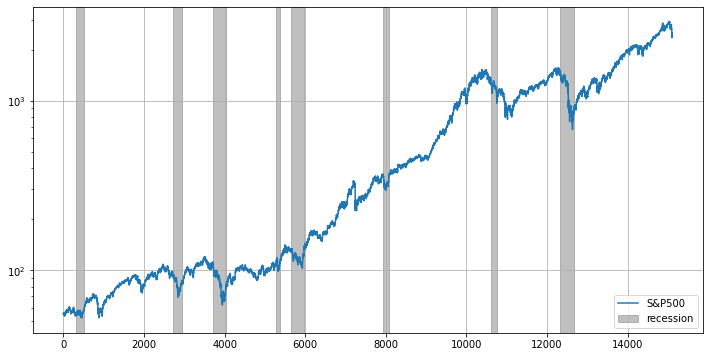

In [14]:
# index of starting recession periods
x1 = np.array(rr)[:-1:2]
# index of ending recession periods
x2 = np.array(rr)[1::2]

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.semilogy(sp500["Adj Close"].values, label="S&P500")
ax.axvspan(x1[0], x2[0], alpha=0.5, color='gray', label="recession")
for i in range(1,len(x1)):
    ax.axvspan(x1[i], x2[i], alpha=0.5, color='gray')
ax.legend()
ax.grid()
plt.show()

This is the same plot using the **plot_regime_color** method based on the trend-filtering algorithm for a given $\lambda$ value (this is not then based on the same regime vector we have used above):

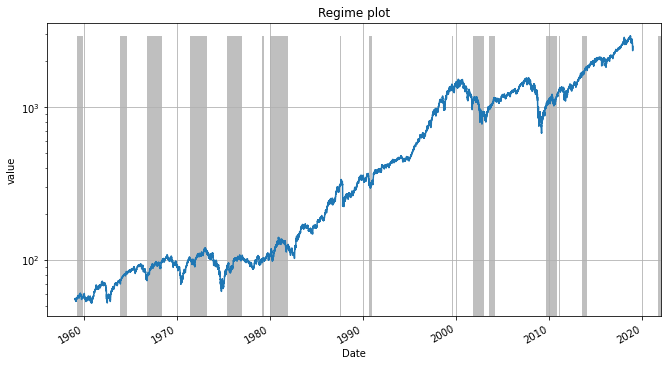

In [15]:
ax = mla.plot_regime_color(sp500["Adj Close"], lambda_value=0.18, figx=11, figy=6)

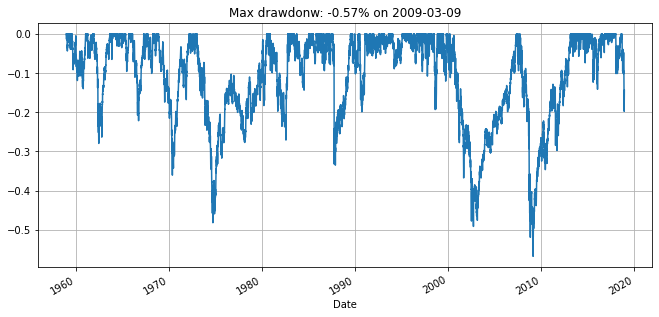

In [16]:
# S&P Drawdowns
previous_peaks = sp500["Adj Close"].cummax()
drawdowns      = (sp500["Adj Close"] - previous_peaks ) / previous_peaks
drawdowns.plot(grid=True, figsize=(11,5), title="Max drawdonw: {:.2f}% on {}".format(drawdowns.min(),str(drawdowns.idxmin()).split()[0]))
plt.show()

## Preprocess the dataset

We will follow the steps below to clean data and make it ready for feature selection process.

1. Remove the variables with missing observations
2. Add lags of the variables as additional features
3. Test stationarity of time series
4. Standardize the dataset

### Remove nans:

In [17]:
# compute the NaN (missing values) per columns and eliminate columns with more than 10 missing values
nan_per_col = bigmacro.isnull().sum()
cols_tobe_removed = nan_per_col[ nan_per_col > 10 ].index
bigmacro = bigmacro.drop(columns=cols_tobe_removed, axis=1)

# and now remove those row containing Nan (i.e. belonging to those columns with less than 10 NaNs)
bigmacro = bigmacro.dropna(axis=0)

In [18]:
bigmacro.shape

(718, 119)

### Adding months lags:

In [19]:
for col in bigmacro.columns[1:]:
    for n in [3,6,9,12,18]:
        bigmacro['{} {}M lag'.format(col, n)] = bigmacro[col].shift(n).ffill().values
        
# 1 month ahead prediction
bigmacro["Regime"] = bigmacro["Regime"].shift(-1)

# remove NaN on rows
bigmacro = bigmacro.dropna(axis=0)

In [20]:
bigmacro.head()

,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
Date,,,,,,,,,,,,,,,,,,,,,
1960-07,Recession,2572.575,2417.0,18.262,293076.0251,18801.00720,23.8433,24.9232,23.6723,34.3040,...,14413.0,14063.0,13804.0,13199.0,12298.0,71.4718,75.4515,76.2235,78.9984,84.2043
1960-08,Recession,2568.401,2410.8,18.245,292706.0518,18865.30897,23.8156,24.8657,23.6723,34.3833,...,14559.0,14144.0,13889.0,13471.0,12298.0,71.6858,73.3363,75.8793,77.3045,83.5280
1960-09,Recession,2571.676,2411.5,18.332,297454.1443,18847.67784,23.5664,24.6642,23.5350,34.2248,...,14816.0,14239.0,14058.0,13657.0,12349.0,71.1864,71.5296,76.1711,76.8926,81.6405
1960-10,Recession,2579.283,2419.1,18.421,291847.7653,19013.61788,23.5387,24.8081,23.6448,34.5814,...,15028.0,14413.0,14063.0,13804.0,12484.0,73.0020,71.4718,75.4515,76.2235,81.8099
1960-11,Recession,2568.231,2405.2,18.357,288992.9599,18741.89106,23.2064,24.5491,23.3702,33.9475,...,15208.0,14559.0,14144.0,13889.0,12646.0,73.0803,71.6858,73.3363,75.8793,80.7315


In [21]:
bigmacro.shape

(699, 709)

### Looking for stationarity

Now, test the stationarity of the series using the **Augmented Dickey-Fuller unit root Test**. 
We will use the **adfuller** method function from **statsmodels** module in Python 
(information __[here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)__).  

The **null hypothesis** of the Augmented Dickey-Fuller **is that there is a unit
root, that is, the time series in NOT stationary**, with the alternative that there is no unit root (i.e., the time series is stationary). 

If the **p-value** is above a critical size (a threshold, a significance level), then we cannot reject that the series is not stationarity (the time series is therefore not stationary).

If a series in our dataset is not stationary we replace it with first-order difference in order to make it stationary:

In [22]:
significance_level = 0.01 

In [23]:
for col in bigmacro.columns[1:]:
    p_value_adf = adfuller( bigmacro[col] )[1] # 1 to select the p-value
    if p_value_adf > significance_level:
        bigmacro[col] = bigmacro[col].diff()
        
bigmacro = bigmacro.dropna(axis=0)  

In [24]:
# repeat
for col in bigmacro.columns[1:]:
    p_value_adf = adfuller( bigmacro[col] )[1]
    if p_value_adf > significance_level:
        bigmacro[col] = bigmacro[col].diff()

bigmacro = bigmacro.dropna(axis=0)  

In [25]:
# repeat 
print("Remaining non stationary series:")
for col in bigmacro.columns[1:]:
    p_value_adf = adfuller( bigmacro[col] )[1] # 1 to select the p-value
    if p_value_adf > significance_level:
        print(col)
bigmacro = bigmacro.dropna(axis=0)  

Remaining non stationary series:
CES0600000008 6M lag


In [26]:
bigmacro.head()

,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
Date,,,,,,,,,,,,,,,,,,,,,
1960-09,Recession,3.275,0.7,0.087,4748.0925,-17.63113,-0.2492,-0.2015,-0.1373,-0.1585,...,257.0,95.0,169.0,186.0,51.0,-0.4994,-1.8067,0.2918,-0.4119,-1.2112
1960-10,Recession,7.607,7.6,0.089,-5606.3790,165.94004,-0.0277,0.1439,0.1098,0.3566,...,212.0,174.0,5.0,147.0,135.0,1.8156,-0.0578,-0.7196,-0.6691,2.0569
1960-11,Recession,-11.052,-13.9,-0.064,-2854.8054,-271.72682,-0.3323,-0.2590,-0.2746,-0.6339,...,180.0,146.0,81.0,85.0,162.0,0.0783,0.2140,-2.1152,-0.3442,-1.2478
1960-12,Recession,-11.710,-14.1,-0.225,2270.7833,-136.90054,-0.4431,-0.3454,-0.3021,-0.2376,...,74.0,257.0,95.0,169.0,280.0,0.9259,-0.4994,-1.8067,0.2918,-0.9559
1961-01,Normal,22.912,20.9,0.044,-10337.0224,14.51975,0.0277,-0.0287,-0.0549,-0.2773,...,-6.0,212.0,174.0,5.0,273.0,1.8713,1.8156,-0.0578,-0.7196,2.3355


### Standardize data using StandardScaler()

In [27]:
features  = bigmacro.drop(["Regime"],axis=1)
col_names = features.columns

# Standardize
scaler = StandardScaler()
scaler.fit(features)
standardized_features = scaler.transform(features)

df = pd.DataFrame(data=standardized_features, columns=col_names)
df.insert(loc=0, column="Regime", value=bigmacro["Regime"].values )
df.index = bigmacro.index

In [28]:
df.shape

(697, 709)

In [29]:
df.head()

,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
Date,,,,,,,,,,,,,,,,,,,,,
1960-09,Recession,-0.277761,-0.295013,-0.212118,0.401363,-0.321981,-0.764446,-0.632790,-0.465458,-0.396755,...,-0.076853,-0.092745,-0.087114,-0.085455,-0.099002,-0.454463,-0.566992,-0.395095,-0.450998,-0.089005
1960-10,Recession,-0.204460,-0.161434,-0.204519,-0.978339,-0.239615,-0.308591,0.059474,-0.009134,0.384548,...,-0.081327,-0.084890,-0.103429,-0.089335,-0.090643,-0.255545,-0.415804,-0.483302,-0.473520,0.147174
1960-11,Recession,-0.520186,-0.577658,-0.785798,-0.611700,-0.435990,-0.935469,-0.748034,-0.719013,-1.117841,...,-0.084509,-0.087674,-0.095868,-0.095503,-0.087956,-0.404823,-0.392308,-0.605015,-0.445070,-0.091651
1960-12,Recession,-0.531320,-0.581530,-1.397470,0.071269,-0.375495,-1.163499,-0.921200,-0.769798,-0.516734,...,-0.095048,-0.076637,-0.094476,-0.087146,-0.076214,-0.331993,-0.453979,-0.578110,-0.389378,-0.070555
1961-01,Normal,0.054513,0.096044,-0.375484,-1.608684,-0.307555,-0.194576,-0.286457,-0.313288,-0.576951,...,-0.103002,-0.081112,-0.086616,-0.103462,-0.076910,-0.250758,-0.253854,-0.425585,-0.477942,0.167308


## Analysis

Now we can start our analysis using the cleaned dataframe we have created above. 
However, let us load and read this dataset from the .csv file that was created beforehand in the coursera application notebook (also because values do not exactly coincides):

In [61]:
# load data
df = pd.read_csv('/Users/r.shyaamprasadh/Downloads/Python and Machine Learning for Asset  Management/Dataset_Cleaned.csv', index_col=0)



In [89]:
years  = np.arange(1960,2018+1,1)
months = np.arange(1,12+1,1)
strdate = []
for y in years:
    for m in months:
        strdate.append( str(y) + "-" + str(m)  )
        if y==2018 and m==7:
            break
strdate = strdate[6:]

In [90]:
len(strdate)

697

In [91]:
df.index = pd.to_datetime(strdate, format="%Y-%m", infer_datetime_format=True).to_period("M") 

In [92]:
df

,Regime,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
1960-07,Recession,-0.277761,-0.295013,-0.212118,0.401363,-0.321981,-0.764446,-0.632790,-0.465458,-0.396755,...,-0.076853,-0.092745,-0.087114,-0.085455,-0.099002,-0.454463,-0.566992,-0.395095,-0.450998,-0.089005
1960-08,Recession,-0.204460,-0.161434,-0.204519,-0.978339,-0.239615,-0.308591,0.059474,-0.009134,0.384548,...,-0.081327,-0.084890,-0.103429,-0.089335,-0.090643,-0.255545,-0.415804,-0.483302,-0.473520,0.147174
1960-09,Recession,-0.520186,-0.577658,-0.785798,-0.611700,-0.435990,-0.935469,-0.748034,-0.719013,-1.117841,...,-0.084509,-0.087674,-0.095868,-0.095503,-0.087956,-0.404823,-0.392308,-0.605015,-0.445070,-0.091651
1960-10,Recession,-0.531320,-0.581530,-1.397470,0.071269,-0.375495,-1.163499,-0.921200,-0.769798,-0.516734,...,-0.095048,-0.076637,-0.094476,-0.087146,-0.076214,-0.331993,-0.453979,-0.578110,-0.389378,-0.070555
1960-11,Normal,0.054513,0.096044,-0.375484,-1.608684,-0.307555,-0.194576,-0.286457,-0.313288,-0.576951,...,-0.103002,-0.081112,-0.086616,-0.103462,-0.076910,-0.250758,-0.253854,-0.425585,-0.477942,0.167308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03,Normal,-0.158774,-0.087869,0.961837,0.428800,2.458364,-2.071505,-3.897094,-4.542461,-4.315554,...,-0.482484,0.035214,-0.213850,0.107884,-0.230363,-2.969053,0.961673,0.029818,0.229887,-2.082950
2018-04,Normal,0.349410,0.372881,0.885853,0.063037,0.230187,1.119480,1.231754,1.612471,0.771786,...,-0.658796,-0.179194,-0.133821,0.236277,-0.197709,-1.758884,2.236719,0.274491,-1.001393,-0.345305
2018-05,Normal,0.225752,0.198647,0.954238,0.150980,1.059808,0.675562,-0.051761,0.152085,0.246822,...,0.108564,-0.311340,-0.144057,-0.120563,-0.293692,-1.727882,-0.918590,0.481157,-0.256506,1.560538
2018-06,Normal,0.496621,0.504524,0.802270,0.788034,-0.474700,1.659097,0.954768,1.176830,0.464180,...,0.104177,-0.482299,0.033552,-0.213885,-0.613278,0.143563,-2.983834,0.964076,0.037260,0.000571


In [93]:
label = df["Regime"].apply(lambda regime: 0 if regime == "Normal" else 1)
df.insert(loc=1, column="label", value=label.values)
df.head()

,Regime,label,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,...,DTCTHFNM 3M lag,DTCTHFNM 6M lag,DTCTHFNM 9M lag,DTCTHFNM 12M lag,DTCTHFNM 18M lag,INVEST 3M lag,INVEST 6M lag,INVEST 9M lag,INVEST 12M lag,INVEST 18M lag
1960-07,Recession,1,-0.277761,-0.295013,-0.212118,0.401363,-0.321981,-0.764446,-0.632790,-0.465458,...,-0.076853,-0.092745,-0.087114,-0.085455,-0.099002,-0.454463,-0.566992,-0.395095,-0.450998,-0.089005
1960-08,Recession,1,-0.204460,-0.161434,-0.204519,-0.978339,-0.239615,-0.308591,0.059474,-0.009134,...,-0.081327,-0.084890,-0.103429,-0.089335,-0.090643,-0.255545,-0.415804,-0.483302,-0.473520,0.147174
1960-09,Recession,1,-0.520186,-0.577658,-0.785798,-0.611700,-0.435990,-0.935469,-0.748034,-0.719013,...,-0.084509,-0.087674,-0.095868,-0.095503,-0.087956,-0.404823,-0.392308,-0.605015,-0.445070,-0.091651
1960-10,Recession,1,-0.531320,-0.581530,-1.397470,0.071269,-0.375495,-1.163499,-0.921200,-0.769798,...,-0.095048,-0.076637,-0.094476,-0.087146,-0.076214,-0.331993,-0.453979,-0.578110,-0.389378,-0.070555
1960-11,Normal,0,0.054513,0.096044,-0.375484,-1.608684,-0.307555,-0.194576,-0.286457,-0.313288,...,-0.103002,-0.081112,-0.086616,-0.103462,-0.076910,-0.250758,-0.253854,-0.425585,-0.477942,0.167308


Our exercise will be based on **classification problem**. 

We have two binary outcomes that we want to predict with certain variables. Here we will summarize our approach to predict recessions with machine learning algorithms:

1. We will perform **feature selection** before making our forecasts: **$L^1$ regularized logistic regression** will be used;

2. Separate dataset into **training and validation (test) sets**: the period **1960-1996** is selected for training and the period over **1996-2018** is kept for validation;

3. Evaluate performances on training dataset **with cross validation (CV)**. Since we have time series structure we will use a special type of CV function in Python, __[`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)__. Then we use the **Receiver operating characteristic (ROC)** as scoring metric in our models. Related Python functions for this metric are __[`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)__  and  __[`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)__;

4. Select **the best performing models based on average accuracy and standard deviation of the CV results**. We take logistic regression as a benchmark model since this is the traditional method has been used to approach this problem;

5. **Make predictions on the test set** with selected models. That is, we first use __[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)__ for the selected model on training dataset to find best combination of parameters for the model. Then we evaluate the model on test set and report accuracy metrics and feature importance results.

#### Separate the features from the targets

In [95]:
df_targets  = df["label"].values
df_features = df.iloc[:,2:]

In [96]:
df_features.shape, df_targets.shape

((697, 708), (697,))

#### Feature selection using logistic regression:

**Logistic regression** is the most commonly used statistical model for binary classification. It uses the logit model of relating log-odds of the dependent variable linearly with the **predictor (explanatory) variables** to learn a form of the following logistic function that is used to separate instances of the two different classes. 

$$
\mathbb{P}(y=1|x) = h_\beta(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1  x)}}, 
$$

where $\beta_0$ is the intercept and $\beta$ is the vector of trained weights.

**The function returns a probability measure** of which class a new instance is given its features. 
This measure is then used to make the final classification with some probability threshold, normally, a value equal to **0.5**.

The specific logistic function is learned through **gradient descent** which focuses on minimizing error calculated through some cost function. A typical approach is to use the following **maximum-likelihood estimator to minimize error in predicted probabilities**:
$$
J(\beta) = - \frac{1}{N} \sum_{i=1}^N y_i \log(h_\beta(x_i)) + (1 - y_i)\log(1 - h_\beta(x_i)),
$$
where $N$ is the number of observations, $h_\beta(x)$ is the function above, and $y_i$ is the predicted class. 
A $L^1$ regularization term:
$$
\lambda\sum_{i=1}^N|\beta_i| 
$$
with $\lambda$ being a regularization parameter is often added to the cost function to **prevent overfitting by penalizing large coefficients**.

In [97]:
scoring = "roc_auc"
kfold   = model_selection.TimeSeriesSplit(n_splits=3)
seed    = 8
max_iter = 10000
penalty = "l1"

X = df_features
y = df_targets

In [98]:
# create regularization hyperparameter space
C = 1 / np.array([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                  0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# create hyperparameter options
#hyperparameters = 

# select the estimator
model = LogisticRegression(max_iter=max_iter, penalty=penalty)

# perform grid-searchCV to tune the pearameters
lr_gscv = GridSearchCV(estimator=model, param_grid= dict(C=C), 
                       cv=kfold, scoring=scoring).fit(X = X, y = y)

# select the best estimator 
lr_gscv_best = lr_gscv.best_estimator_
lr_gscv_best

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [99]:
# now that we have the best estimator do the penalized linear regression 
lr_l1 = LogisticRegression(C=lr_gscv_best.C, max_iter=lr_gscv_best.max_iter, penalty=penalty).fit(X=X, y=y)

In [100]:
# features selection 
model = SelectFromModel(lr_l1, prefit=True)

In [101]:
# features (columns) that have been selected 
features_idx  = model.get_support()
features_name = df_features.columns[features_idx]

# finally reduce actual dataset to the selected features
df_reduced = model.transform(df_features)
df_reduced = pd.DataFrame(df_reduced, index=df_features.index, columns=features_name)
df_reduced.shape

(697, 36)

In [102]:
# look at the selected features 
features_name, len(features_name)

(Index(['DPCERA3M086SBEA', 'IPFPNSS', 'IPMANSICS', 'HWI', 'UNRATE', 'PAYEMS',
        'SRVPRD', 'USTPU', 'USWTRADE', 'USFIRE', 'HOUST', 'HOUSTW',
        'S&P div yield', 'TB3MS', 'TB3SMFFM', 'IPMAT 9M lag', 'IPDMAT 12M lag',
        'CLAIMSx 9M lag', 'DMANEMP 12M lag', 'USFIRE 3M lag', 'AWOTMAN 18M lag',
        'BUSLOANS 6M lag', 'S&P 500 6M lag', 'S&P div yield 3M lag',
        'TB3MS 6M lag', 'AAA 3M lag', 'TB3SMFFM 3M lag', 'T1YFFM 6M lag',
        'T5YFFM 6M lag', 'T10YFFM 6M lag', 'T10YFFM 12M lag', 'BAAFFM 12M lag',
        'EXUSUKx 12M lag', 'WPSID62 9M lag', 'OILPRICEx 9M lag',
        'CUSR0000SAD 3M lag'],
       dtype='object'),
 36)

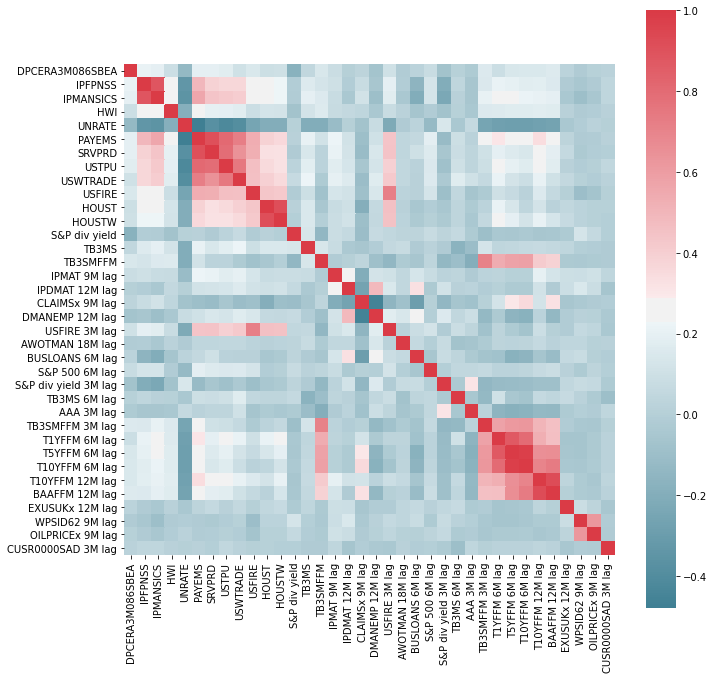

In [103]:
# look at the correlation matrix 
df_reduced_corr = df_reduced.corr()
fig, ax = plt.subplots(1,1,figsize=(11, 11))
sns.heatmap(df_reduced_corr, ax=ax, mask=np.zeros_like(df_reduced_corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)
plt.show()

#### Training the algorithms

First of all we create the **train set** and the **test set**:

#### Training the algorithms

First of all we create the **train set** and the **test set**:

In [106]:
split_1 = "1996-11"
split_2 = "1996-12"
df_train_features = df_reduced[:split_1]
df_test_features  = df_reduced[split_2:]

df_train_targets = df["label"][:split_1]
df_test_targets  = df["label"][split_2:] 

print( df_train_features.shape, df_train_targets.shape )
print( df_test_features.shape, df_test_targets.shape )

(437, 36) (437,)
(260, 36) (260,)


In [107]:
# collect models 
models   = []
models.append( ('LR', LogisticRegression(C=1e09)) )
models.append( ('LR_L1', LogisticRegression(penalty='l1')) )
models.append( ('LR_L2', LogisticRegression(penalty='l2')) )
models.append( ('LDA', LinearDiscriminantAnalysis()) )
models.append( ('KNN', KNeighborsClassifier()) )
models.append( ('GB', GradientBoostingClassifier()) )
models.append( ('ABC', AdaBoostClassifier()) )
models.append( ('RF', RandomForestClassifier()) )
#models.append( ('XGB', xgb.XGBClassifier()) )

In [108]:
seed     = 8
scoring  = "roc_auc" 
n_splits = 4
kfold    = model_selection.TimeSeriesSplit(n_splits=n_splits) 

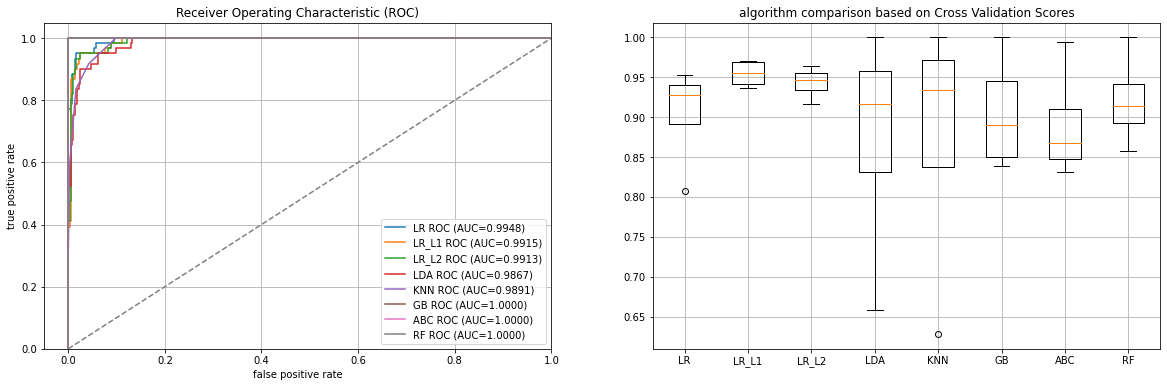

In [109]:
cv_res = []
names  = []

fig, ax = plt.subplots(1,2,figsize=(20,6))
#print("        CV mean CV std")

for name, model in models:
    # train current model
    model.fit(df_train_features, df_train_targets) 
    y_score = model.predict_proba(df_train_features)[:,1]

    # compute roc curve
    fpr, tpr, thresholds = roc_curve(df_train_targets, y_score)
    
    # area under the ROC curve
    auc = roc_auc_score(df_train_targets, y_score)
    
    # cross-validation
    cv_results = model_selection.cross_val_score(estimator=model, cv=kfold, scoring=scoring,
                                                 X = df_train_features, 
                                                 y = LabelBinarizer().fit_transform(df_train_targets)) 

    ax[0].plot(fpr, tpr, label="{} ROC (AUC={:.4f})".format(name,auc) )
    #print( "{}:\t{:.4f}\t({:.4f})".format(name,cv_results.mean(),cv_results.std()))

    cv_res.append(cv_results)
    names.append(name)
    
ax[0].plot([0, 1], [0, 1], color="gray", linestyle="--")
ax[0].set_xlim([-0.05, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('false positive rate')
ax[0].set_ylabel('true positive rate')
ax[0].set_title('Receiver Operating Characteristic (ROC)')
ax[0].legend()
ax[0].grid()

ax[1].boxplot(cv_res)
ax[1].set_xticklabels(names)
ax[1].set_title('algorithm comparison based on Cross Validation Scores')
ax[1].grid()

plt.show() 

#### Find recession regimes dates

In [110]:
# dates of normal and recession regimes
df_targets = pd.Series(df_targets, index=df_features.index)
normal_dates     = df_targets[df_targets==0.0].index
recessions_dates = df_targets[df_targets==1.0].index

# find indices of recession regimes 
rec_idx = np.zeros_like(recessions_dates)
rec_idx[0] = 1
for i, date in enumerate(recessions_dates):
    prev_date = date - 1
    if prev_date not in recessions_dates:
        rec_idx[i] = 1
        rec_idx[i-1] = 1
rec_idx = np.array([False if i==0 else True for i in rec_idx])
#recessions_dates[rec_idx]

# index of starting recession periods
x1 = np.array( recessions_dates[rec_idx] )[:-1:2]
# index of ending recession periods
x2 = np.array( recessions_dates[rec_idx] )[1::2]

#### Make predictions

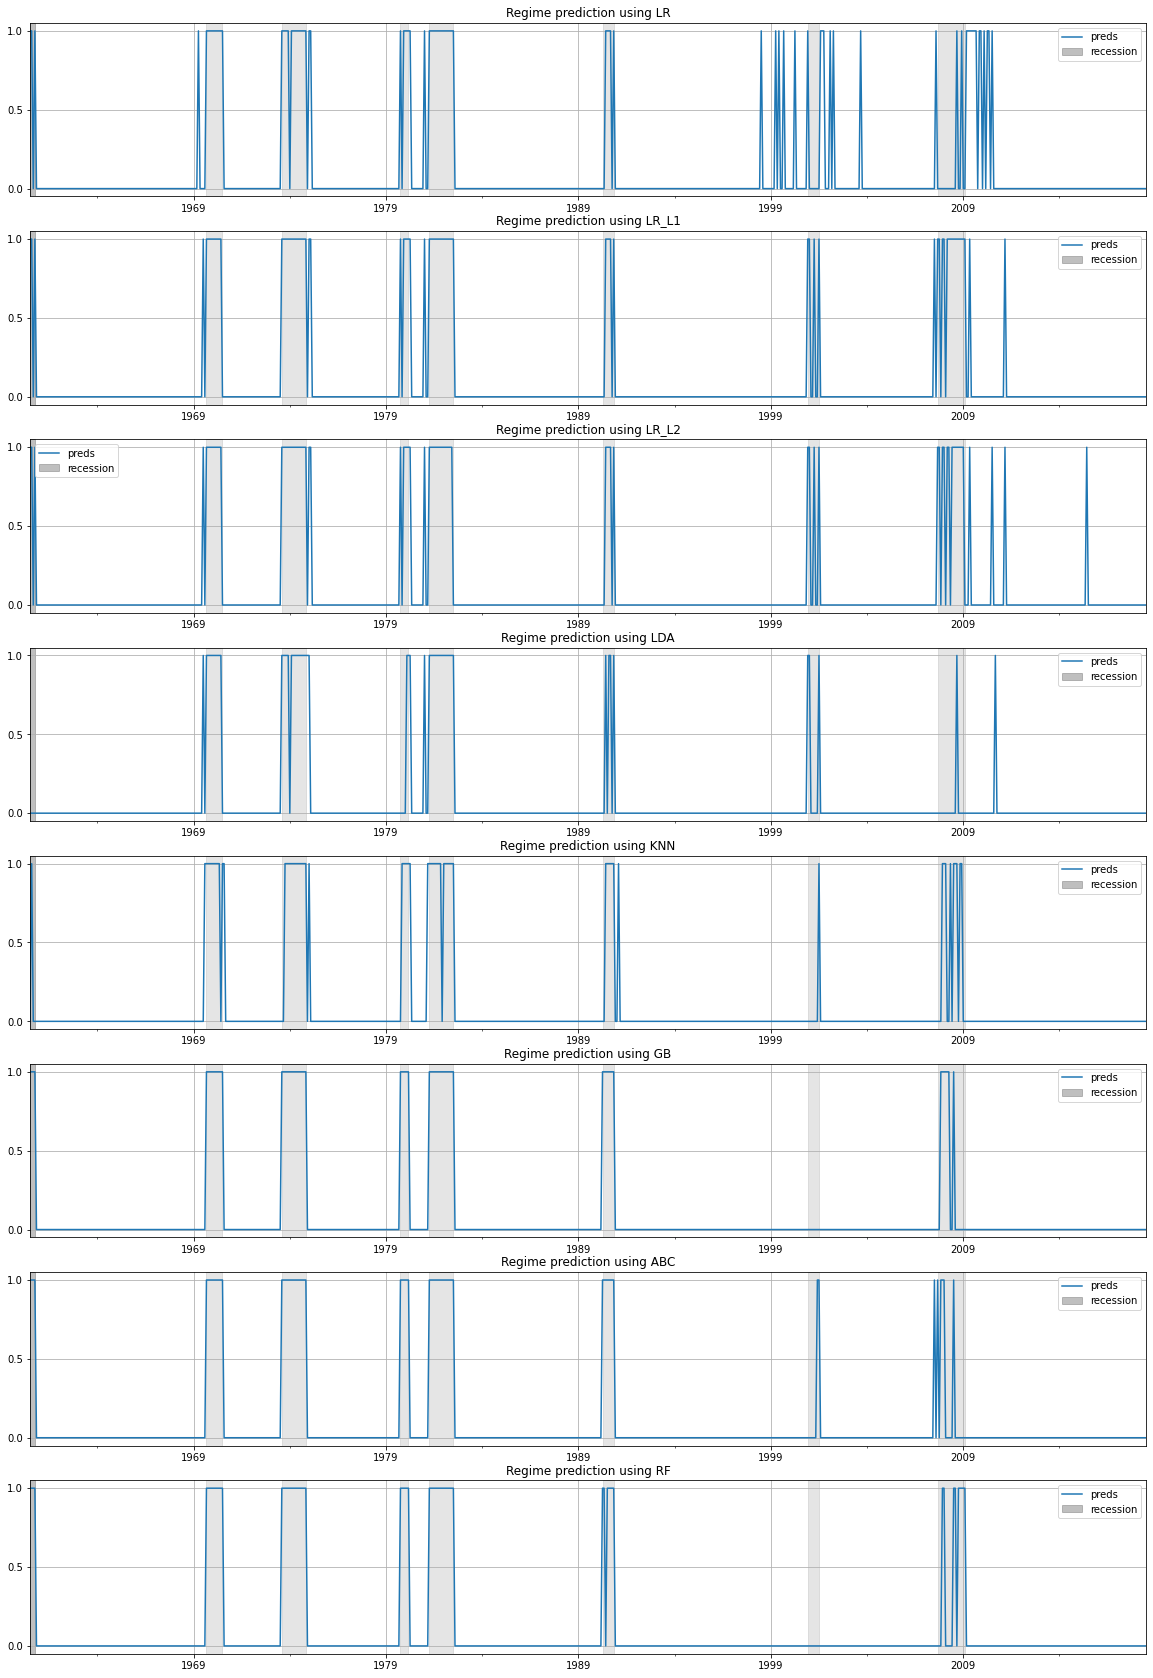

In [112]:
fig, ax = plt.subplots(len(models),1,figsize=(20,30))

for i,model in enumerate(models):
    model_fit = model[1].fit(df_train_features, df_train_targets)

    # prediction on the train set
    train_preds = pd.Series( model_fit.predict(df_train_features), index=df_train_targets.index, name="preds")
    # classes probabilities train set
    train_prob_preds = pd.DataFrame( model_fit.predict_proba(df_train_features), index=df_train_targets.index, columns=["Normal","Recession"])
    train_preds = pd.concat([train_preds, train_prob_preds], axis=1)

    # prediction on the test set
    test_preds = pd.Series( model_fit.predict(df_test_features), index=df_test_targets.index, name="preds")
    # classes probabilities test set
    test_prob_preds = pd.DataFrame( model_fit.predict_proba(df_test_features), index=df_test_targets.index, columns=["Normal","Recession"])
    test_preds  = pd.concat([test_preds, test_prob_preds], axis=1)

    # concat train and test prediction
    total_preds = pd.concat([train_preds,test_preds], axis=0)
    
    # plot
    total_preds["preds"].plot(ax=ax[i], grid=True)
    ax[i].axvspan(x1[0], x2[0], alpha=0.5, color='gray', label="recession")
    for j in range(1,len(x1)):
        ax[i].axvspan(x1[j], x2[j], alpha=0.2, color='gray')
    #ax.axvline(x=300, linestyle="--", color="r")
    ax[i].set_title("Regime prediction using {}".format(model[0]))
    ax[i].legend()
    ax[i].set_yticks([0,0.5,1]) #labels(names)

plt.show()